## Churn

1. Set Up Spark Context

In [34]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder \
    .appName("Churn Prediction") \
    .getOrCreate()

# Check Spark Context
print(spark)


2. Load Necessary Libraries

In [35]:
from pyspark.sql.functions import col, when, count, mean, corr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns


3. Check Information Provided About Data

In [36]:
# Load the data
df = spark.read.csv("Churn.csv", header=True, inferSchema=True)

# Show dataframe schema and basic info
df.printSchema()
df.show(5)


root
 |-- AccountLength: integer (nullable = true)
 |-- VMailMessage: integer (nullable = true)
 |-- DayMins: double (nullable = true)
 |-- EveMins: double (nullable = true)
 |-- NightMins: double (nullable = true)
 |-- IntlMins: double (nullable = true)
 |-- CustServCalls: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- IntlPlan: integer (nullable = true)
 |-- VMailPlan: integer (nullable = true)
 |-- DayCalls: integer (nullable = true)
 |-- DayCharge: double (nullable = true)
 |-- EveCalls: integer (nullable = true)
 |-- EveCharge: double (nullable = true)
 |-- NightCalls: integer (nullable = true)
 |-- NightCharge: double (nullable = true)
 |-- IntlCalls: integer (nullable = true)
 |-- IntlCharge: double (nullable = true)
 |-- State: string (nullable = true)
 |-- AreaCode: integer (nullable = true)
 |-- Phone: string (nullable = true)

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+-------

4. Import Data Files from HDFS

In [37]:
# Assuming data is already in HDFS, load with Spark DataFrame
#df = spark.read.csv("hdfs:///path/to/Churn.csv", header=True, inferSchema=True)


5. Display the Data in Spark Dataframe

( Note:: In pyspark, dataframe index the rows from 0
instead of 1)

In [38]:
# Display first few rows
df.show(10)


+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|       0|        1|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|       0|        1|     123|    27.47|     103|    16.62|       103|      11.45| 

6. Data Pre-processing

Do data pre-processing required? ( Hint - We have some variables which should be of
categorical datatype but they are of type integer. Convert them)


In [39]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import StringType

# Step 1: Identify columns to convert
# IntlPlan and VMailPlan should be categorical, let's convert them from integers (0/1) to string type.
# Additionally, you may want to consider other columns if their integer values represent categories.

# Convert 'IntlPlan' and 'VMailPlan' from integers to categorical (string) types
df = df.withColumn("IntlPlan", when(col("IntlPlan") == 1, "Yes").otherwise("No"))
df = df.withColumn("VMailPlan", when(col("VMailPlan") == 1, "Yes").otherwise("No"))

# If 'CustServCalls' is considered categorical (e.g., each call count is a distinct category), it should be converted
# However, generally this would remain numeric unless specified otherwise.
# For this example, let's assume we keep 'CustServCalls' as numeric.

# Show updated schema and data preview
df.printSchema()
df.show(5)

# If needed, cast to StringType explicitly
df = df.withColumn("IntlPlan", df["IntlPlan"].cast(StringType()))
df = df.withColumn("VMailPlan", df["VMailPlan"].cast(StringType()))

# Verify changes
df.printSchema()

root
 |-- AccountLength: integer (nullable = true)
 |-- VMailMessage: integer (nullable = true)
 |-- DayMins: double (nullable = true)
 |-- EveMins: double (nullable = true)
 |-- NightMins: double (nullable = true)
 |-- IntlMins: double (nullable = true)
 |-- CustServCalls: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- IntlPlan: string (nullable = false)
 |-- VMailPlan: string (nullable = false)
 |-- DayCalls: integer (nullable = true)
 |-- DayCharge: double (nullable = true)
 |-- EveCalls: integer (nullable = true)
 |-- EveCharge: double (nullable = true)
 |-- NightCalls: integer (nullable = true)
 |-- NightCharge: double (nullable = true)
 |-- IntlCalls: integer (nullable = true)
 |-- IntlCharge: double (nullable = true)
 |-- State: string (nullable = true)
 |-- AreaCode: integer (nullable = true)
 |-- Phone: string (nullable = true)

+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+-------

### Missing Values

Identify Missing Values

In [40]:
from pyspark.sql.functions import col, isnan, when, count

# Check for missing values in each column
missing_data = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
missing_data.show()


+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+-----+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+-----+
|            0|           0|      0|      0|        0|       0|            0|    0|       0|        0|       0|        0|       0|        0|         0|          0|        0|         0|    0|       0|    0|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+---

Drop Missing Values

In [41]:
# Replace 'ColumnName1', 'ColumnName2' with actual column names that have missing values
df_cleaned = df.dropna(subset=["DayMins", "EveMins"])  # Example with actual column names


In [42]:
# Print column names to confirm
print(df.columns)

['AccountLength', 'VMailMessage', 'DayMins', 'EveMins', 'NightMins', 'IntlMins', 'CustServCalls', 'Churn', 'IntlPlan', 'VMailPlan', 'DayCalls', 'DayCharge', 'EveCalls', 'EveCharge', 'NightCalls', 'NightCharge', 'IntlCalls', 'IntlCharge', 'State', 'AreaCode', 'Phone']


Impute Missing Values

In [43]:
from pyspark.ml.feature import Imputer

# Imputer for numerical columns - fill with mean, median, etc.
imputer = Imputer(
    inputCols=["DayMins", "EveMins", "NightMins", "IntlMins"], 
    outputCols=["DayMins", "EveMins", "NightMins", "IntlMins"]
).setStrategy("mean")  # or "median"

# Fit the imputer and transform the DataFrame
df_imputed = imputer.fit(df).transform(df)


### Duplicates

 Identify Duplicates

In [44]:
# Check the total number of rows in the original DataFrame
total_rows = df.count()

# Check the number of distinct rows in the DataFrame
distinct_rows = df.distinct().count()

# Calculate the number of duplicate rows
duplicates = total_rows - distinct_rows
print(f"Total rows: {total_rows}, Distinct rows: {distinct_rows}, Duplicates: {duplicates}")


Total rows: 3333, Distinct rows: 3333, Duplicates: 0


Remove Duplicates

In [45]:
# Remove all duplicate rows
df_no_duplicates = df.dropDuplicates()

# Verify the removal
print(f"Rows after removing duplicates: {df_no_duplicates.count()}")


Rows after removing duplicates: 3333


### Outliers

1. Identify Outliers

Using IQR to Identify Outliers:

In [46]:
from pyspark.sql.functions import col, when

# Calculate Q1 and Q3 for the 'DayMins' column
q1, q3 = df.approxQuantile("DayMins", [0.25, 0.75], 0.05)  # 0.05 is the relative error for approximation
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Identify outliers
outliers = df.filter((col("DayMins") < lower_bound) | (col("DayMins") > upper_bound))
outliers.show()




Lower bound: 46.0, Upper bound: 310.0
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          161|           0|  332.9|  317.8|    160.6|     5.4|            4|    1|      No|       No|      67|    56.59|      97|    27.01|       128|       7.23|        9|      1.46|   NY|     415|351-7269|
|           83|           0|  337.4|  227.4|    153.9|    15.8|            0|    1|      No|       No|     120|    57.36|     

2. Visualize Outliers

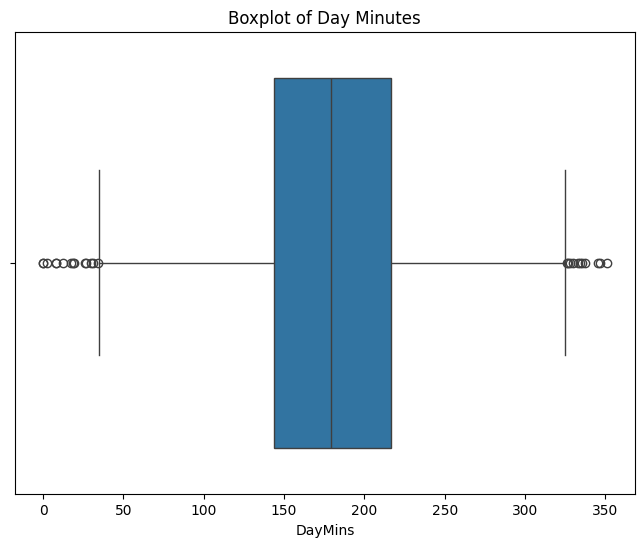

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
df_pd = df.select("DayMins").toPandas()

# Boxplot to visualize outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_pd["DayMins"])
plt.title("Boxplot of Day Minutes")
plt.show()


3. Handle Outliers

Removing Outliers

In [48]:
# Remove outliers based on IQR
df_no_outliers = df.filter((col("DayMins") >= lower_bound) & (col("DayMins") <= upper_bound))
df_no_outliers.show()


+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|      No|      Yes|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|      No|      Yes|     123|    27.47|     103|    16.62|       103|      11.45| 

Transforming Data

In [49]:
# Log transformation to reduce the impact of outliers
from pyspark.sql.functions import log1p

df_transformed = df.withColumn("LogDayMins", log1p(col("DayMins")))
df_transformed.show()


+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+------------------+
|AccountLength|VMailMessage|DayMins|EveMins|NightMins|IntlMins|CustServCalls|Churn|IntlPlan|VMailPlan|DayCalls|DayCharge|EveCalls|EveCharge|NightCalls|NightCharge|IntlCalls|IntlCharge|State|AreaCode|   Phone|        LogDayMins|
+-------------+------------+-------+-------+---------+--------+-------------+-----+--------+---------+--------+---------+--------+---------+----------+-----------+---------+----------+-----+--------+--------+------------------+
|          128|          25|  265.1|  197.4|    244.7|    10.0|            1|    0|      No|      Yes|     110|    45.07|      99|    16.78|        91|      11.01|        3|       2.7|   KS|     415|382-4657| 5.583872177983643|
|          107|          26|  161.6|  195.5|    254.4|    13.7|            1|    0|     

7. Do exploratory data analysis

 7.1 - Describe the data using describe the function and state your insights.

In [50]:
# Describe the data to get basic statistics
df.describe().show()

# Insights:
# - Check mean, min, max, and standard deviation for each numerical feature.
# - Identify any anomalies or unexpected values (e.g., extremely high standard deviations indicating outliers).
# - Compare means to understand general customer behavior patterns in calls, charges, and plans.


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------+---------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----+------------------+--------+
|summary|     AccountLength|      VMailMessage|           DayMins|           EveMins|         NightMins|          IntlMins|     CustServCalls|              Churn|IntlPlan|VMailPlan|          DayCalls|         DayCharge|          EveCalls|         EveCharge|        NightCalls|      NightCharge|         IntlCalls|        IntlCharge|State|          AreaCode|   Phone|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------+---------+------------------+------------------+------------------+------------------+---------

7.2 Create Histogram for Day Minutes Spent by Customers for churn=0 and churn=1 Values

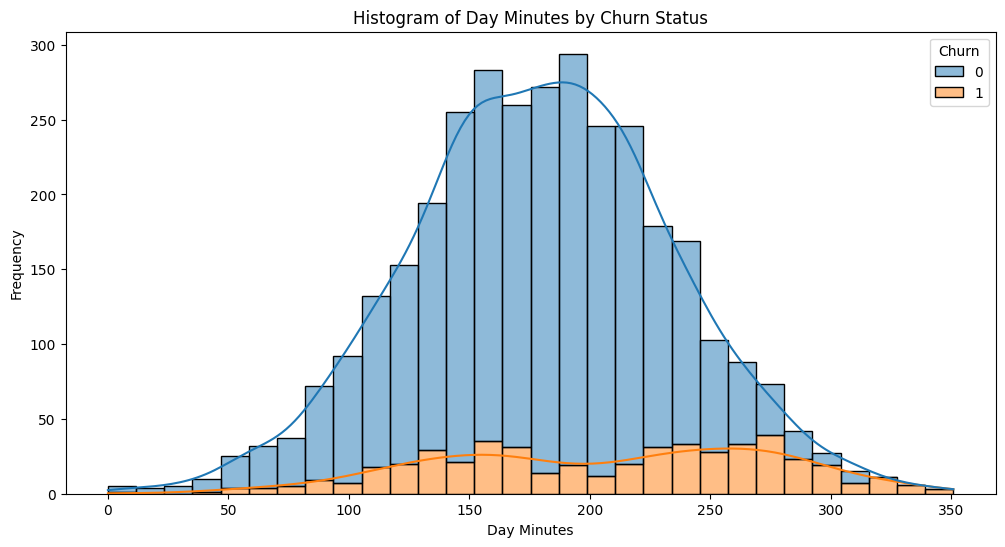

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas for visualization
df_pd = df.select("DayMins", "Churn").toPandas()

# Create histograms for Day Minutes based on churn status
plt.figure(figsize=(12, 6))
sns.histplot(data=df_pd, x="DayMins", hue="Churn", bins=30, kde=True, multiple="stack")
plt.title("Histogram of Day Minutes by Churn Status")
plt.xlabel("Day Minutes")
plt.ylabel("Frequency")
plt.show()

# Insights:
# - This will show the distribution of Day Minutes for churned and non-churned customers.
# - Look for differences in distributions that might suggest high usage correlates with churn.


7.3 Create Count Plots for Number of Customers Opting for Voicemail Plan with Churn Values

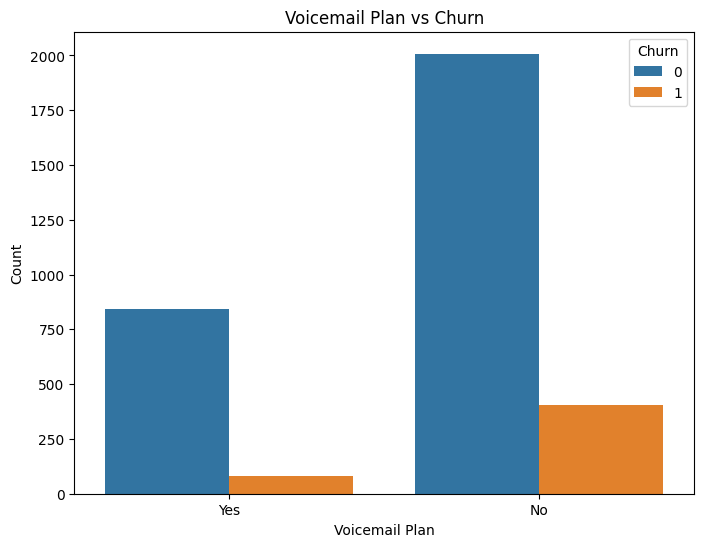

In [52]:
# Convert relevant columns to Pandas for visualization
df_pd_vmail = df.select("VMailPlan", "Churn").toPandas()

# Create count plot for Voicemail Plan vs. Churn
plt.figure(figsize=(8, 6))
sns.countplot(data=df_pd_vmail, x="VMailPlan", hue="Churn")
plt.title("Voicemail Plan vs Churn")
plt.xlabel("Voicemail Plan")
plt.ylabel("Count")
plt.show()

# Insights:
# - Compare churn rates between customers with and without a voicemail plan.
# - Look for patterns indicating whether having a voicemail plan affects churn rates.


7.4 Create Count Plots for International Plan Opted by the Customer with Churn Values

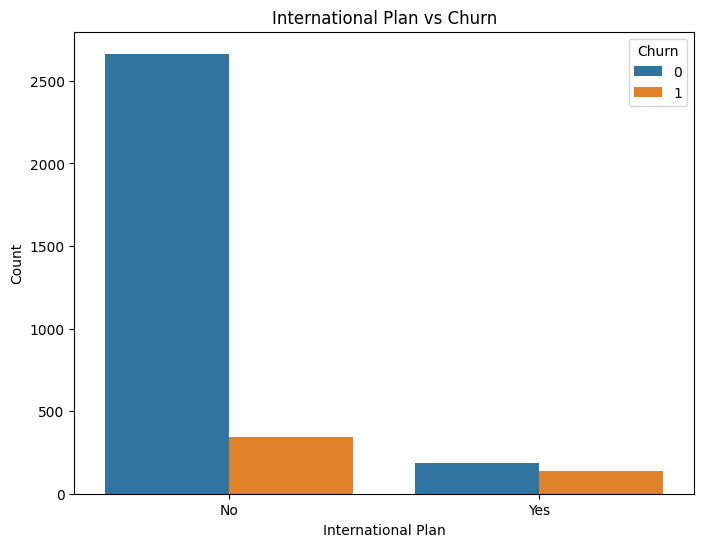

In [53]:
# Convert relevant columns to Pandas for visualization
df_pd_intl = df.select("IntlPlan", "Churn").toPandas()

# Create count plot for International Plan vs. Churn
plt.figure(figsize=(8, 6))
sns.countplot(data=df_pd_intl, x="IntlPlan", hue="Churn")
plt.title("International Plan vs Churn")
plt.xlabel("International Plan")
plt.ylabel("Count")
plt.show()

# Insights:
# - Assess whether having an international plan influences churn.
# - High churn among international plan users could indicate a pricing or satisfaction issue with that service.


7.5 Plot Area-Wise Churner and Non-Churner

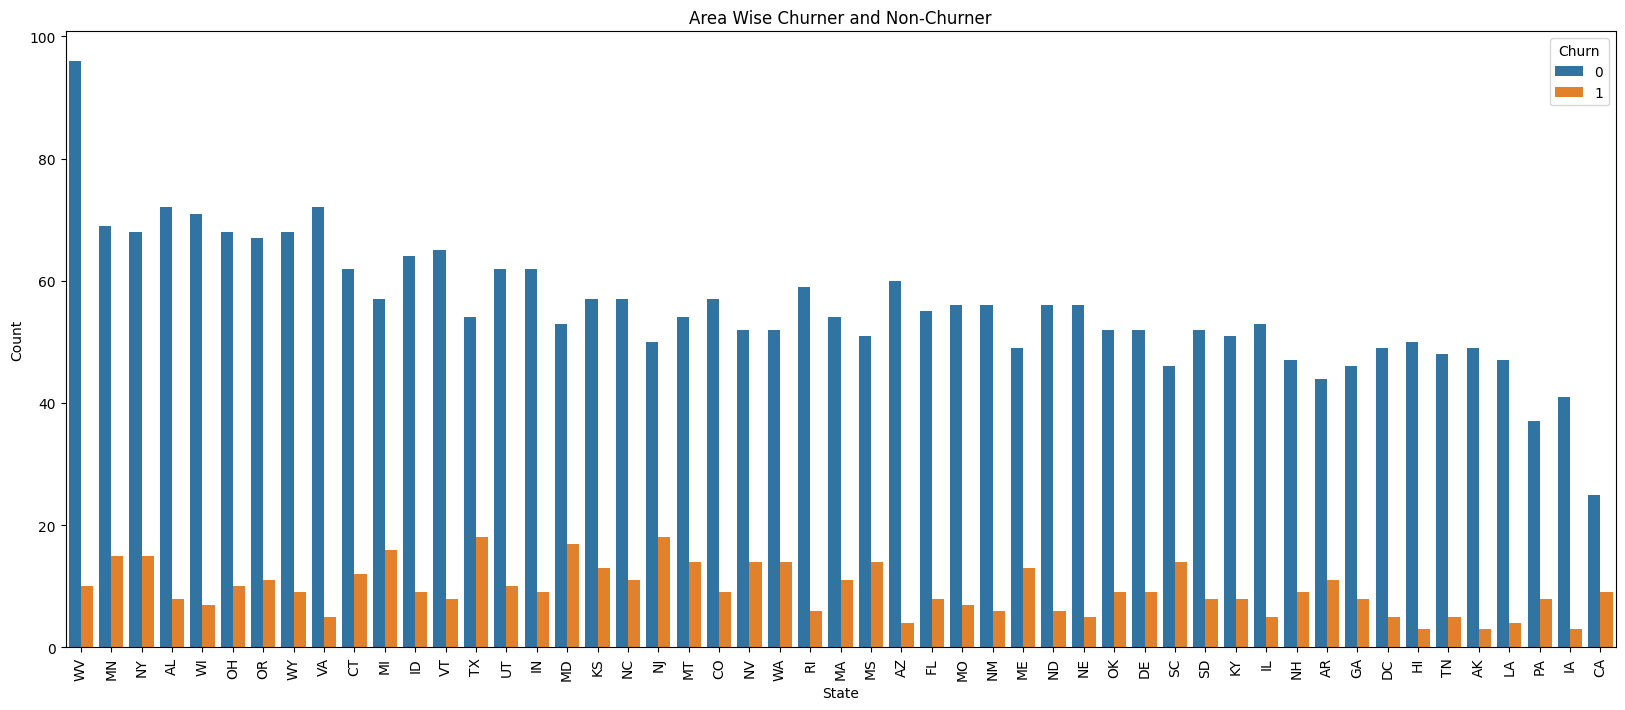

In [54]:
# Convert relevant columns to Pandas for visualization
df_pd_area = df.select("State", "Churn").toPandas()

# Create count plot for churn by state
plt.figure(figsize=(20, 8))
sns.countplot(data=df_pd_area, x="State", hue="Churn", order=df_pd_area['State'].value_counts().index)
plt.title("Area Wise Churner and Non-Churner")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

# Insights:
# - Identify areas (states) with higher churn rates.
# - Helps in targeted marketing or customer retention strategies in high-churn areas.


7.6 Get Correlation Matrix Using corr() Function

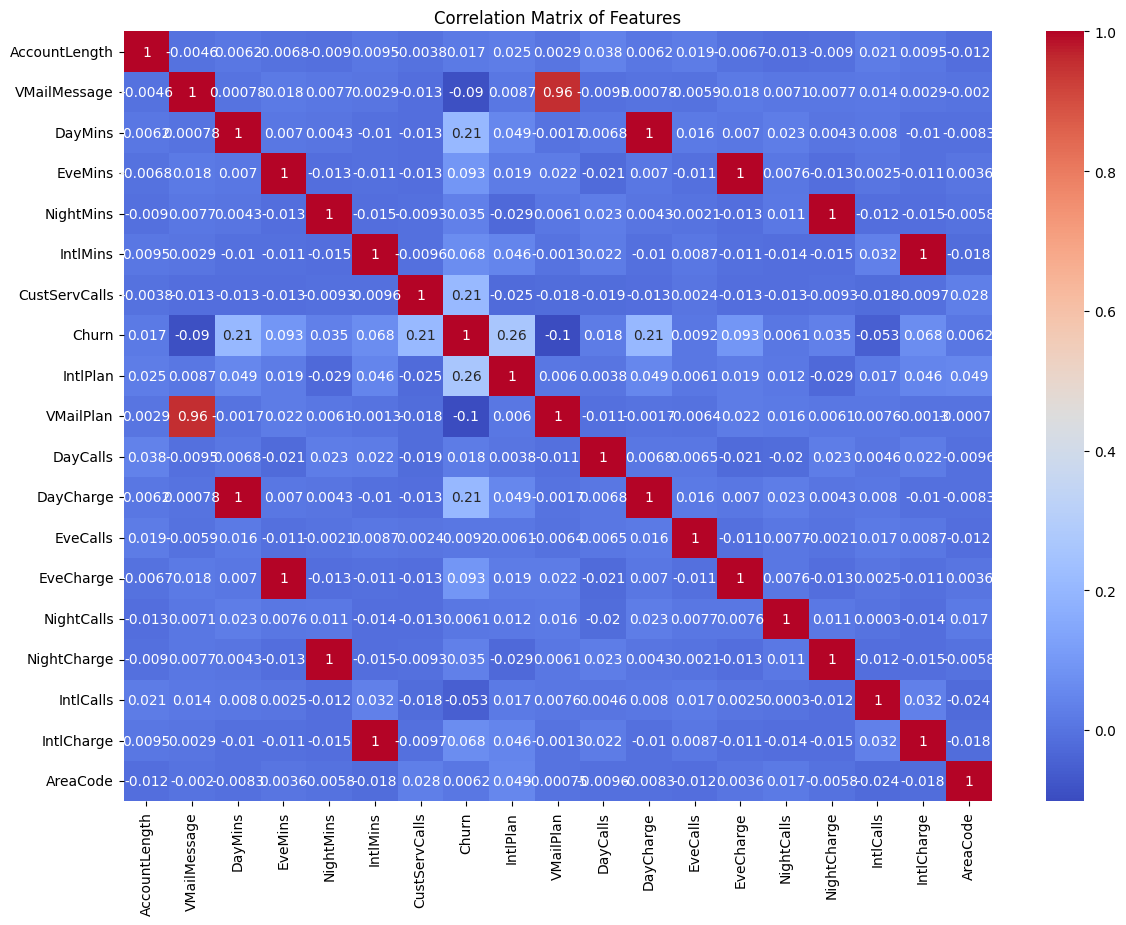

In [56]:
# Convert categorical variables to numeric
df_pd_corr = df.toPandas()

# Example: Convert 'IntlPlan' and 'VMailPlan' from Yes/No to 1/0
df_pd_corr['IntlPlan'] = df_pd_corr['IntlPlan'].map({'Yes': 1, 'No': 0})
df_pd_corr['VMailPlan'] = df_pd_corr['VMailPlan'].map({'Yes': 1, 'No': 0})

# Ensure all other categorical variables are converted as needed
# For example, 'Churn' should already be 0 and 1
# Check other categorical columns and convert if necessary

# Drop non-numeric columns that are not necessary for correlation
df_pd_corr = df_pd_corr.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = df_pd_corr.corr()

# Plot the correlation matrix using a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()


8. Correlation Between Predicting Variable and Independent Variable

In [57]:
# Check correlation between Churn and other variables
df_corr = df.select([corr("Churn", col).alias(col) for col in df.columns if col != "Churn"])
df_corr.show()


+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------+---------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-----+--------------------+-----+
|      AccountLength|        VMailMessage|            DayMins|            EveMins|          NightMins|           IntlMins|     CustServCalls|IntlPlan|VMailPlan|           DayCalls|         DayCharge|           EveCalls|          EveCharge|          NightCalls|        NightCharge|           IntlCalls|         IntlCharge|State|            AreaCode|Phone|
+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------+---------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+----------

9. Applying Machine Learning Models

9.1 Import Necessary Libraries

In [60]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col


9.2 Create Vectors of All Independent Variables

Label Encoding Using StringIndexer

Label encoding converts categorical values into numeric indices. For example, it converts "Yes" and "No" into 0 and 1.

In [61]:
# Convert categorical columns 'IntlPlan' and 'VMailPlan' to numeric using StringIndexer
intl_plan_indexer = StringIndexer(inputCol="IntlPlan", outputCol="IntlPlanIndex")
vmail_plan_indexer = StringIndexer(inputCol="VMailPlan", outputCol="VMailPlanIndex")

# Create a vector of all independent variables
assembler = VectorAssembler(
    inputCols=[
        "AccountLength", "VMailMessage", "DayMins", "EveMins", "NightMins", "IntlMins",
        "CustServCalls", "IntlPlanIndex", "VMailPlanIndex", "DayCalls", "DayCharge",
        "EveCalls", "EveCharge", "NightCalls", "NightCharge", "IntlCalls", "IntlCharge"
    ], 
    outputCol="features"
)


9.3 Apply Decision Tree Classifier Using Dependent and Independent Variables

In [62]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features")


9.4 Create a Pipeline to Build the Classifier

In [63]:
# Create a pipeline including the indexers and the classifier
pipeline_dt = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, dt])


9.5 Use Stratified Sampling to Get a Sample of Data


Stratified sampling is not directly available in PySpark, but you can achieve it by splitting the dataset based on the target class ratios.

In [64]:
# Get class counts for stratified sampling
churn_0 = df.filter(col("Churn") == 0)
churn_1 = df.filter(col("Churn") == 1)

# Set proportions based on class distribution
fraction_0 = 0.7 * (churn_0.count() / df.count())
fraction_1 = 0.7 * (churn_1.count() / df.count())

# Stratified sampling
train_0 = churn_0.sample(withReplacement=False, fraction=fraction_0, seed=1234)
train_1 = churn_1.sample(withReplacement=False, fraction=fraction_1, seed=1234)

# Combine samples for training data
train = train_0.union(train_1)

# Use the rest as the test set
test = df.subtract(train)


9.6 Split the Data into Train and Test Dataset

Alternatively, using a simpler random split if exact stratification is not needed:

In [65]:
# Randomly split the data into train (70%) and test (30%)
train, test = df.randomSplit([0.7, 0.3], seed=1234)


9.7 Make Predictions and Validate Your Model by Calculating the Accuracy Score

In [66]:
# Fit the model using the pipeline
model_dt = pipeline_dt.fit(train)

# Make predictions on the test set
predictions_dt = model_dt.transform(test)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")


Decision Tree Accuracy: 0.9352818371607515


9.8 Calculate Recall and Precision Score

In [67]:
# Calculate recall and precision scores
recall_dt = evaluator.setMetricName("weightedRecall").evaluate(predictions_dt)
precision_dt = evaluator.setMetricName("weightedPrecision").evaluate(predictions_dt)
print(f"Decision Tree Recall: {recall_dt}, Precision: {precision_dt}")


Decision Tree Recall: 0.9352818371607516, Precision: 0.9328771876182624


9.10 Repeat Steps from 9.3 to 9.9 for Random-Forest and Gradient-Boost Classifiers

Random Forest Classifier

In [68]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features")

# Create a pipeline
pipeline_rf = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, rf])

# Fit the model
model_rf = pipeline_rf.fit(train)

# Make predictions
predictions_rf = model_rf.transform(test)

# Evaluate accuracy
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Evaluate recall and precision
recall_rf = evaluator.setMetricName("weightedRecall").evaluate(predictions_rf)
precision_rf = evaluator.setMetricName("weightedPrecision").evaluate(predictions_rf)
print(f"Random Forest Recall: {recall_rf}, Precision: {precision_rf}")


Random Forest Accuracy: 0.9096642435637803
Random Forest Recall: 0.907098121085595, Precision: 0.9096642435637803


Gradient-Boosted Tree Classifier

In [69]:
# Initialize Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="Churn", featuresCol="features", maxIter=10)

# Create a pipeline
pipeline_gbt = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, gbt])

# Fit the model
model_gbt = pipeline_gbt.fit(train)

# Make predictions
predictions_gbt = model_gbt.transform(test)

# Evaluate accuracy
accuracy_gbt = evaluator.evaluate(predictions_gbt)
print(f"Gradient-Boosted Tree Accuracy: {accuracy_gbt}")

# Evaluate recall and precision
recall_gbt = evaluator.setMetricName("weightedRecall").evaluate(predictions_gbt)
precision_gbt = evaluator.setMetricName("weightedPrecision").evaluate(predictions_gbt)
print(f"Gradient-Boosted Tree Recall: {recall_gbt}, Precision: {precision_gbt}")


Gradient-Boosted Tree Accuracy: 0.9472822548633705
Gradient-Boosted Tree Recall: 0.9488517745302714, Precision: 0.9472822548633705


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importance
def plot_feature_importance(importance, feature_names, model_name):
    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()


Visualizing Feature Importance for Random Forest and Gradient-Boosted Trees


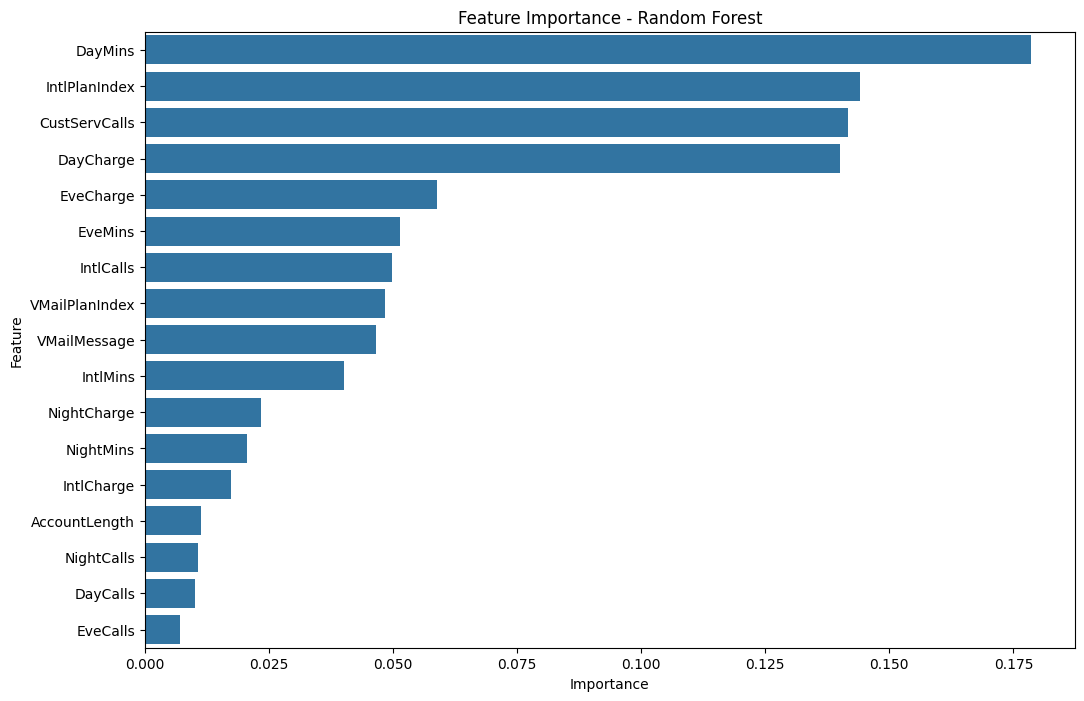

In [71]:
# Get feature importance from Random Forest model
rf_feature_importance = model_rf.stages[-1].featureImportances.toArray()

# Define the feature names (these should match the input columns to the VectorAssembler)
feature_names = [
    "AccountLength", "VMailMessage", "DayMins", "EveMins", "NightMins", "IntlMins",
    "CustServCalls", "IntlPlanIndex", "VMailPlanIndex", "DayCalls", "DayCharge",
    "EveCalls", "EveCharge", "NightCalls", "NightCharge", "IntlCalls", "IntlCharge"
]

# Plot feature importance for Random Forest
plot_feature_importance(rf_feature_importance, feature_names, model_name="Random Forest")


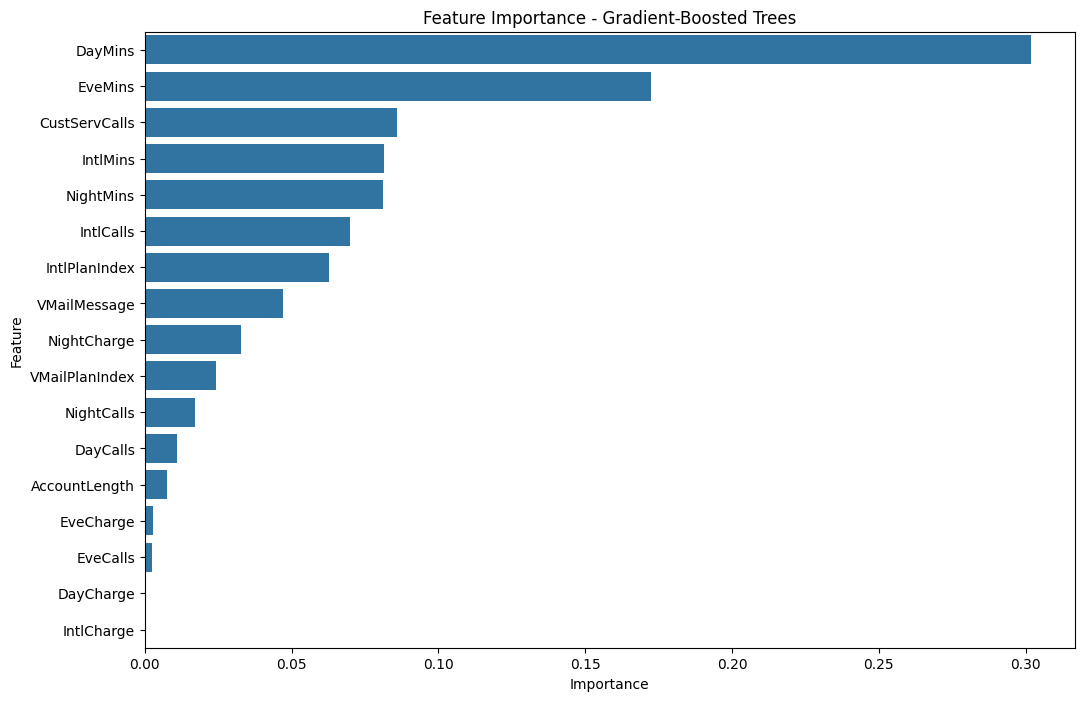

In [72]:
# Get feature importance from Gradient-Boosted Trees model
gbt_feature_importance = model_gbt.stages[-1].featureImportances.toArray()

# Plot feature importance for Gradient-Boosted Trees
plot_feature_importance(gbt_feature_importance, feature_names, model_name="Gradient-Boosted Trees")


Plot the ROC Curve

Make Predictions on the Test Set

In [73]:
# Make predictions using Random Forest and Gradient-Boosted Trees
predictions_rf = model_rf.transform(test)
predictions_gbt = model_gbt.transform(test)


In [74]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Extract probability column as an array
predictions_rf = predictions_rf.withColumn("probability_array", vector_to_array(col("probability")))

# Extract only the probability of the positive class (Churn = 1)
predictions_rf = predictions_rf.withColumn("prob_positive", col("probability_array")[1])

# Use BinaryClassificationEvaluator to calculate AUC
evaluator = BinaryClassificationEvaluator(labelCol="Churn", rawPredictionCol="prob_positive", metricName="areaUnderROC")
roc_auc_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest AUC: {roc_auc_rf}")


Random Forest AUC: 0.9128019220043758


In [75]:
# Extract probability column as an array
predictions_gbt = predictions_gbt.withColumn("probability_array", vector_to_array(col("probability")))

# Extract only the probability of the positive class (Churn = 1)
predictions_gbt = predictions_gbt.withColumn("prob_positive", col("probability_array")[1])

# Use BinaryClassificationEvaluator to calculate AUC
roc_auc_gbt = evaluator.evaluate(predictions_gbt)
print(f"Gradient-Boosted Trees AUC: {roc_auc_gbt}")


Gradient-Boosted Trees AUC: 0.9023982152816507


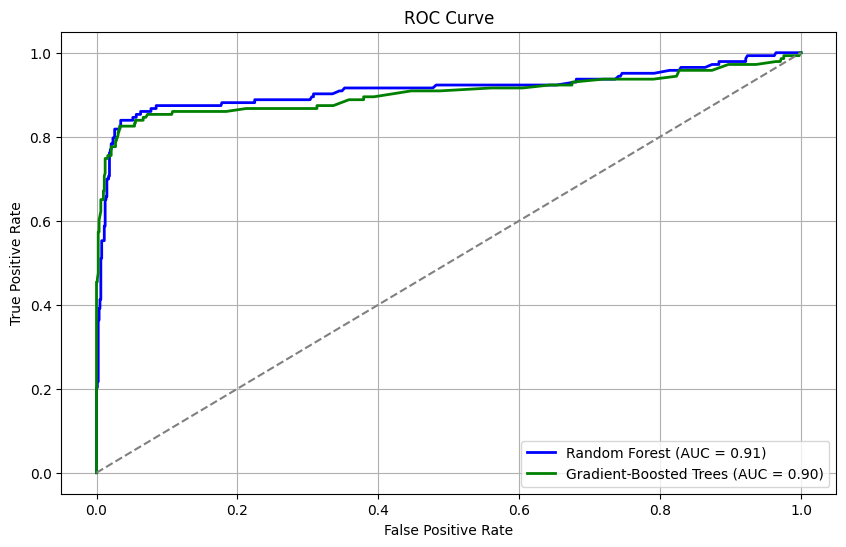

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert probabilities and true labels to Pandas for ROC calculation
rf_pd = predictions_rf.select("prob_positive", "Churn").toPandas()
gbt_pd = predictions_gbt.select("prob_positive", "Churn").toPandas()

# Calculate ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(rf_pd["Churn"], rf_pd["prob_positive"])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Calculate ROC curve and AUC for Gradient-Boosted Trees
fpr_gbt, tpr_gbt, _ = roc_curve(gbt_pd["Churn"], gbt_pd["prob_positive"])
roc_auc_gbt = auc(fpr_gbt, tpr_gbt)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gbt, tpr_gbt, color='green', lw=2, label=f'Gradient-Boosted Trees (AUC = {roc_auc_gbt:.2f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Compare Model Metrics Visually

In [77]:
# Metrics collected from previous steps
metrics = {
    "Model": ["Decision Tree", "Random Forest", "Gradient-Boosted Trees"],
    "Accuracy": [accuracy_dt, accuracy_rf, accuracy_gbt],
    "Recall": [recall_dt, recall_rf, recall_gbt],
    "Precision": [precision_dt, precision_rf, precision_gbt],
    "AUC": [roc_auc_rf, roc_auc_rf, roc_auc_gbt]  # Assuming AUC was calculated
}


In [78]:
import pandas as pd

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)


                    Model  Accuracy    Recall  Precision       AUC
0           Decision Tree  0.935282  0.935282   0.932877  0.912802
1           Random Forest  0.909664  0.907098   0.909664  0.912802
2  Gradient-Boosted Trees  0.947282  0.948852   0.947282  0.902398


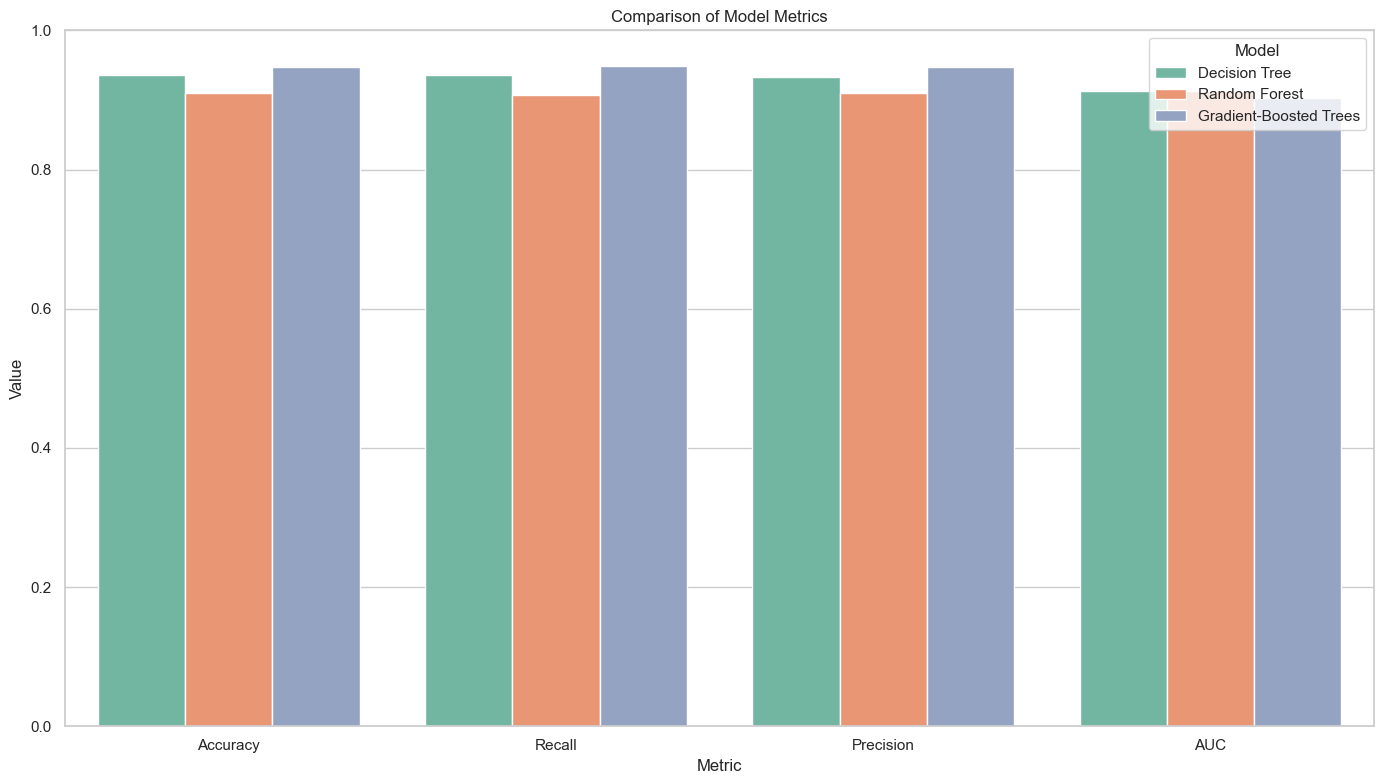

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style and size
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Melt the DataFrame to a long format for easier plotting
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Create a grouped bar plot to compare model metrics
sns.barplot(x="Metric", y="Value", hue="Model", data=metrics_melted, palette="Set2")

# Add titles and labels
plt.title("Comparison of Model Metrics")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.ylim(0, 1)  # Set the y-axis limit for better visualization

# Display the legend and plot
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()


Create and Visualize Confusion Matrices

In [80]:
# Predictions from models (already obtained previously)
# predictions_dt, predictions_rf, predictions_gbt


In [81]:
# Convert to Pandas for confusion matrix calculations
dt_pd = predictions_dt.select("prediction", "Churn").toPandas()
rf_pd = predictions_rf.select("prediction", "Churn").toPandas()
gbt_pd = predictions_gbt.select("prediction", "Churn").toPandas()


In [82]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices for each model
conf_matrix_dt = confusion_matrix(dt_pd["Churn"], dt_pd["prediction"])
conf_matrix_rf = confusion_matrix(rf_pd["Churn"], rf_pd["prediction"])
conf_matrix_gbt = confusion_matrix(gbt_pd["Churn"], gbt_pd["prediction"])


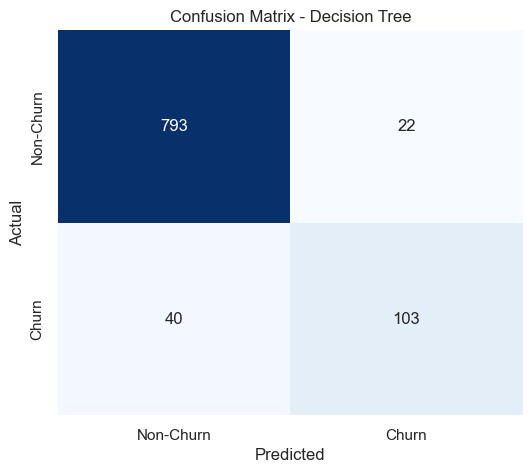

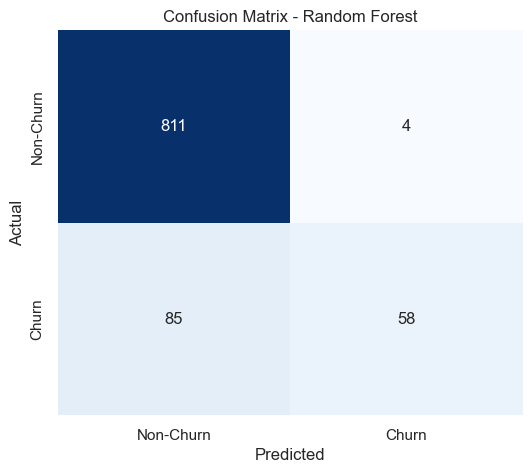

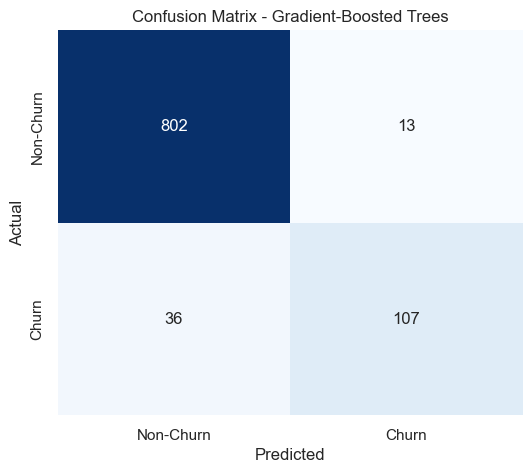

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Non-Churn', 'Churn'],
                yticklabels=['Non-Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(conf_matrix_dt, "Decision Tree")
plot_confusion_matrix(conf_matrix_rf, "Random Forest")
plot_confusion_matrix(conf_matrix_gbt, "Gradient-Boosted Trees")


Fine-Tune Models in PySpark

Step 1: Import Necessary Libraries

In [84]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer


Step 2: Define Hyperparameter Grids

For Decision Tree Classifier

In [85]:
# Define the Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features")

# Define the parameter grid
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [32, 40, 50]) \
    .build()


For Random Forest Classifier

In [86]:
# Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features")

# Define the parameter grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()


For Gradient-Boosted Trees Classifier


In [87]:
# Define the Gradient-Boosted Trees classifier
gbt = GBTClassifier(labelCol="Churn", featuresCol="features", maxIter=10)

# Define the parameter grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.stepSize, [0.1, 0.2, 0.3]) \
    .build()


Step 3: Set Up Cross-Validation

In [88]:
# Define the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="accuracy")

# Cross-Validator for Decision Tree
crossval_dt = CrossValidator(estimator=dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=evaluator,
                             numFolds=3)  # Number of folds in cross-validation

# Cross-Validator for Random Forest
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=3)

# Cross-Validator for Gradient-Boosted Trees
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=3)


Step 4: Create Pipelines Including Indexers and Assemblers

In [89]:
# Define indexers and assembler
intl_plan_indexer = StringIndexer(inputCol="IntlPlan", outputCol="IntlPlanIndex")
vmail_plan_indexer = StringIndexer(inputCol="VMailPlan", outputCol="VMailPlanIndex")
assembler = VectorAssembler(
    inputCols=[
        "AccountLength", "VMailMessage", "DayMins", "EveMins", "NightMins", "IntlMins",
        "CustServCalls", "IntlPlanIndex", "VMailPlanIndex", "DayCalls", "DayCharge",
        "EveCalls", "EveCharge", "NightCalls", "NightCharge", "IntlCalls", "IntlCharge"
    ],
    outputCol="features"
)

# Create pipelines
pipeline_dt = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, crossval_dt])
pipeline_rf = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, crossval_rf])
pipeline_gbt = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, assembler, crossval_gbt])


Step 5: Fit Models Using Cross-Validation

In [90]:
# Split the data into training and test datasets
train, test = df.randomSplit([0.7, 0.3], seed=1234)

# Fit the models with cross-validation
cv_model_dt = pipeline_dt.fit(train)
cv_model_rf = pipeline_rf.fit(train)
cv_model_gbt = pipeline_gbt.fit(train)


Step 6: Evaluate the Best Models on the Test Set


In [91]:
# Evaluate the best models on the test set
predictions_dt = cv_model_dt.transform(test)
predictions_rf = cv_model_rf.transform(test)
predictions_gbt = cv_model_gbt.transform(test)

# Evaluate accuracy for each model
accuracy_dt = evaluator.evaluate(predictions_dt)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_gbt = evaluator.evaluate(predictions_gbt)

print(f"Decision Tree Best Model Accuracy: {accuracy_dt}")
print(f"Random Forest Best Model Accuracy: {accuracy_rf}")
print(f"Gradient-Boosted Trees Best Model Accuracy: {accuracy_gbt}")


Decision Tree Best Model Accuracy: 0.9331941544885177
Random Forest Best Model Accuracy: 0.9572025052192067
Gradient-Boosted Trees Best Model Accuracy: 0.9509394572025052


Label and OneHot Encoding

Label Encoding with StringIndexer: Converts categorical string columns into numerical indices. Each unique category is assigned a unique integer index.

One-Hot Encoding with OneHotEncoder: Converts numerical indices from label encoding into binary vectors. Each category is represented by a distinct binary column.

Pipeline: The pipeline chains these transformations so that they can be applied sequentially, making the process clean and manageable.

Step 1: Import Necessary Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


Step 2: Define Indexers for Label Encoding

In [ ]:
# Create StringIndexers for label encoding categorical variables
intl_plan_indexer = StringIndexer(inputCol="IntlPlan", outputCol="IntlPlanIndex")
vmail_plan_indexer = StringIndexer(inputCol="VMailPlan", outputCol="VMailPlanIndex")

# If you have other categorical columns, add more StringIndexers similarly


Step 3: Define One-Hot Encoders for One-Hot Encoding

In [ ]:
# Create OneHotEncoders to convert indexed categorical features to binary (one-hot encoded) features
intl_plan_encoder = OneHotEncoder(inputCols=["IntlPlanIndex"], outputCols=["IntlPlanVec"])
vmail_plan_encoder = OneHotEncoder(inputCols=["VMailPlanIndex"], outputCols=["VMailPlanVec"])

# Add more encoders if you have other categorical columns that need to be one-hot encoded


Step 4: Create a Pipeline for Encoding

In [ ]:
# Create a pipeline that includes all the steps for encoding
pipeline = Pipeline(stages=[intl_plan_indexer, vmail_plan_indexer, intl_plan_encoder, vmail_plan_encoder])


Step 5: Fit and Transform the Data

In [ ]:
# Assuming you have already loaded your DataFrame into 'df'

# Fit the pipeline on the dataset and transform it
model = pipeline.fit(df)
encoded_df = model.transform(df)

# Show the resulting DataFrame with encoded columns
encoded_df.select("IntlPlan", "IntlPlanIndex", "IntlPlanVec", "VMailPlan", "VMailPlanIndex", "VMailPlanVec").show()


Only OneHot

In [92]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


In [93]:
spark = SparkSession.builder.appName("OneHotEncoding").getOrCreate()


In [94]:
# Example DataFrame creation
data = [
    ("A", 1.0, "X"),
    ("B", 2.0, "Y"),
    ("C", 3.0, "Z"),
    ("A", 4.0, "X"),
]

columns = ["Category1", "Value", "Category2"]
df = spark.createDataFrame(data, columns)


Define the columns to be one-hot encoded:

In [95]:
columns_to_encode = ["Category1", "Category2"]


Create a pipeline of StringIndexer and OneHotEncoder for each column:


In [96]:
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in columns_to_encode]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_onehot") for col in columns_to_encode]

pipeline = Pipeline(stages=indexers + encoders)


Fit and transform the data:

In [97]:
model = pipeline.fit(df)
encoded_df = model.transform(df)


Py4JJavaError: An error occurred while calling o27178.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 17 in stage 4938.0 failed 1 times, most recent failure: Lost task 17.0 in stage 4938.0 (TID 4882) (LAPTOP-2SGNE4HI executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1570)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more


View the results:

In [ ]:
encoded_df.show()


Label Encode

In [98]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.sql import DataFrame


In [ ]:
spark = SparkSession.builder \
    .appName("Label Encoding") \
    .getOrCreate()



In [ ]:
# Define the columns you want to label encode
columns_to_encode = ["category1", "category2"]

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_encoded")
    df = indexer.fit(df).transform(df)


In [ ]:
df.show()
